## Fine tuning classification with OpenAI

In [4]:
import pandas as pd
import openai 
import os
from datasets import load_dataset
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import math

from dotenv import load_dotenv
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

SEED = 42

random.seed(SEED)

/opt/conda/envs/llms/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Casting to class labels: 100%|██████████| 288065/288065 [00:00<00:00, 349441.63 examples/s]


Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [5]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [7]:
dataset['train']

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 172839
})

In [6]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df.head()

,package_name,review,date,star
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0
4,com.google.android.gms,Ok,April 29 2017,2


In [8]:
training_df[['review']].sample(5)

,review
171063,GREAT SOUND--SMALL SIZE--NO ADS Repeat and Shu...
93363,It is poor connbection
40388,Excellent work. Very useful. Works seamlessly ...
164565,Great complement to native voltage tracking
70450,Spettacolare Grandioso fa tutto quello che dev...


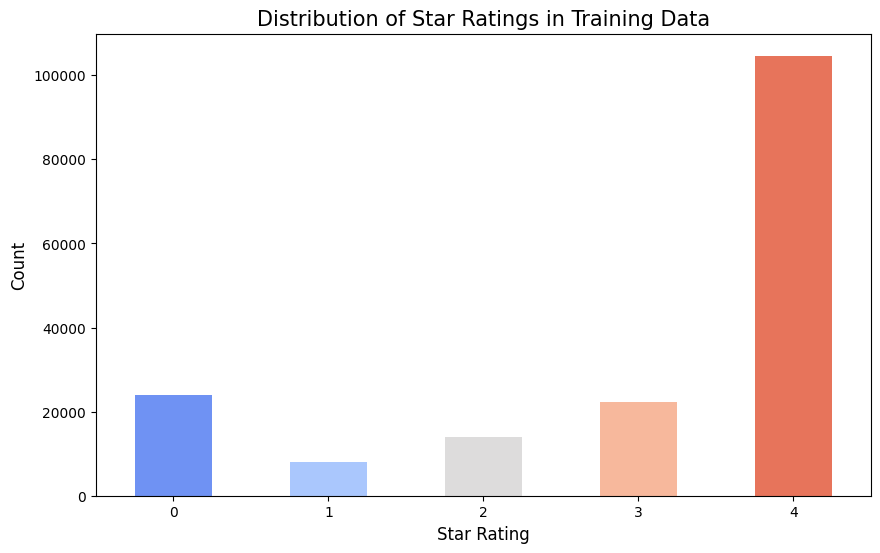

In [9]:
# Counting the number of occurrences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# Creating the bar plot to show distribution of star ratings given
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
star_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(star_counts)))

# Adding titles and labels for clarity
plt.title('Distribution of Star Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)  # Ensure the x-axis labels are horizontal for better readability

# Displaying the chart
plt.show()

In [10]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

### Sentiment Prediction (star column)

In [11]:
# Creating the 'prompt' column in each dataset (training, validation, and test) by adding a separator '###\n' to the 'review' column.
# This separator is often used in fine-tuning to signal where the prompt ends and the expected output begins.
training_df['prompt'] = training_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'

In [14]:
training_df['prompt'].head()

0                                         Nice😉\n###\n
1    Google play service Just one ward its amazing ...
2                                    Mr Perfect\n###\n
3    Does not work with Tmobile S4 If you try to in...
4                                            Ok\n###\n
Name: prompt, dtype: object

In [15]:
# Converting the 'star' column in each dataset to a string format and storing it in the 'completion' column.
# The 'completion' column will be used as the target variable for sentiment analysis.
training_df['completion'] = training_df['star'].astype(str)  # for sentiment
val_df['completion'] = val_df['star'].astype(str)  # for sentiment
test_df['completion'] = test_df['star'].astype(str)  # for sentiment

In [16]:
# Creating a training dataset in JSONL format after dropping duplicates based on the 'prompt' column.
# Random sampling ensures the data is shuffled.
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient='records', lines=True
)

In [17]:
# Creating another version of the training dataset in JSONL format, but this time ordering by 'completion' column (star ratings).
# This ordered set might be useful for specific training strategies.
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].sort_values('completion').to_json(
    "app-review-full-train-sentiment-ordered.jsonl", orient='records', lines=True
)

In [18]:
# Creating a validation dataset in JSONL format after dropping duplicates based on the 'prompt' column.
val_df.sample(
    len(val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

# Creating a test dataset in JSONL format after dropping duplicates based on the 'prompt' column.
test_df.sample(
    len(test_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-test-sentiment-random.jsonl", orient='records', lines=True
)

In [19]:
training_df.head()

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0,Mr Perfect\n###\n,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0,Does not work with Tmobile S4 If you try to in...,0
4,com.google.android.gms,Ok,April 29 2017,2,Ok\n###\n,2


In [20]:
def get_data_dict(row, system=''):
    return {
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

## Using OpenAI's Fine-tuning API

In [1]:
import json

In [2]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random.jsonl", "rb").readlines()[0])

{'prompt': 'Excellent\n###\n', 'completion': '3'}

In [5]:
# Creating a file object for the training dataset with OpenAI's API.
# The 'file' parameter specifies the path to the training data in JSONL format.
# The 'purpose' is set to 'fine-tune', indicating the file's intended use.
training_file = openai.File.create(
  file=open("app-review-full-train-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
val_file = openai.File.create(
  file=open("app-review-full-val-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)

In [ ]:
# Initiating the fine-tuning process with OpenAI's API.

# The `openai.FineTuningJob.create` method is used to start the training.
# Parameters include:
# - `training_file`: The ID of the previously uploaded training dataset file.
# - `validation_file`: The ID of the previously uploaded validation dataset file.
# - `model`: The base model to be fine-tuned. In this case, "babbage-002" is chosen.
# - `hyperparameters`: Dictionary containing training hyperparameters. Here, we specify the number of epochs as 1.
job = openai.FineTuningJob.create(
    training_file=training_file.id,
    validation_file=val_file.id,
    model="babbage-002",
    hyperparameters={'n_epochs': 1}
)

In [ ]:
# Retrieving details of an ongoing or completed fine-tuning job using OpenAI's API.

# The `openai.FineTuningJob.retrieve` method fetches the job details based on its ID.
# This can be used to monitor the progress, status, or retrieve results of the training job.
job = openai.FineTuningJob.retrieve(job.id)

In [ ]:
job

In [ ]:
# Downloading the results of the completed fine-tuning job using OpenAI's API.

# The `openai.File.download` method is used to fetch the result files.
# `job.result_files[0]` gets the ID of the first result file associated with the job.
results = openai.File.download(job.result_files[0])

# Decoding the downloaded bytes to obtain a string representation of the results.
ans = results.decode()

# Saving the decoded results into a CSV file.
# Opening (or creating) a file named 'results.csv' in write mode.
with open('results.csv', 'w') as f:
    f.write(ans)

In [ ]:
results_df = pd.read_csv('results.csv')

results_df.head()